In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/5
28/28 [==============================] - 17s 488ms/step - loss: 1.0502 - accuracy: 0.4989 - val_loss: 0.9987 - val_accuracy: 0.5291
Epoch 2/5
28/28 [==============================] - 14s 494ms/step - loss: 0.9906 - accuracy: 0.5472 - val_loss: 1.0205 - val_accuracy: 0.5291
Epoch 3/5
28/28 [==============================] - 14s 487ms/step - loss: 0.9891 - accuracy: 0.5472 - val_loss: 0.9987 - val_accuracy: 0.5291
Epoch 4/5
28/28 [==============================] - 14s 490ms/step - loss: 0.9807 - accuracy: 0.5472 - val_loss: 0.9956 - val_accuracy: 0.5291
Epoch 5/5
28/28 [==============================] - 14s 498ms/step - loss: 0.9756 - accuracy: 0.5472 - val_loss: 1.0057 - val_accuracy: 0.5291
7/7 - 0s - loss: 1.0057 - accuracy: 0.5291 - 192ms/epoch - 27ms/step
Test Loss: 1.0056695938110352
Test Accuracy: 0.5291479825973511
7/7 [==============================] - 0s 20ms/step


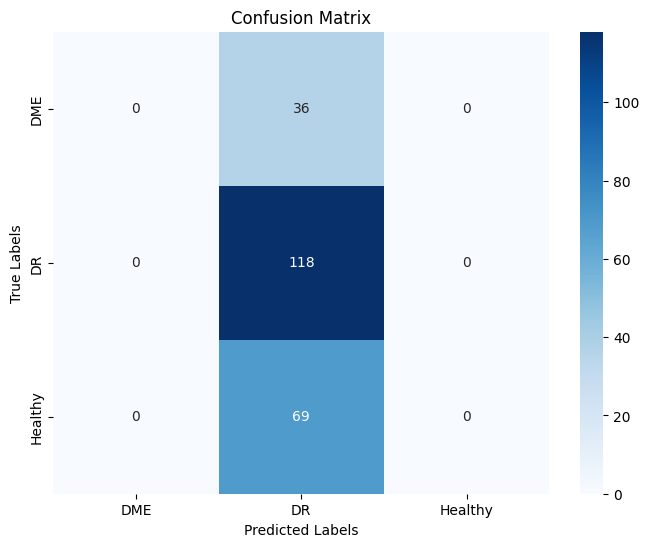

              precision    recall  f1-score   support

         DME       0.00      0.00      0.00        36
          DR       0.53      1.00      0.69       118
     Healthy       0.00      0.00      0.00        69

    accuracy                           0.53       223
   macro avg       0.18      0.33      0.23       223
weighted avg       0.28      0.53      0.37       223



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Multiply, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Set the paths to your dataset
dataset_path = '/content/drive/MyDrive/RISC2023/OCT-AND-EYE-FUNDUS-DATASET/OCT-AND-EYE-FUNDUS-DATASET-main/oct'
dme_path = os.path.join(dataset_path, 'OCT_DME')
dr_path = os.path.join(dataset_path, 'OCT_DR')
healthy_path = os.path.join(dataset_path, 'OCT_HEALTHY')

# Set the image dimensions
image_width, image_height = 256, 256

# Load the images and labels
images = []
labels = []

for class_path, class_label in [(dme_path, 0), (dr_path, 1), (healthy_path, 2)]:
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (image_width, image_height))
        images.append(image)
        labels.append(class_label)

# Convert the data to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Perform train-test split
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Perform data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(train_images)

# Convert labels to one-hot encoded vectors
num_classes = 3
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

# Define the region guided attention network
input_tensor = Input(shape=(image_width, image_height, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

attention = GlobalAveragePooling2D()(x)
attention = Dense(256, activation='relu')(attention)
attention = Dense(1, activation='sigmoid')(attention)
attention = Multiply()([x, attention])

x = GlobalAveragePooling2D()(attention)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model1 = Model(inputs=input_tensor, outputs=x)

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 5
history = model1.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(test_images, test_labels))

# Evaluate the model on the test set
test_loss, test_accuracy = model1.evaluate(test_images, test_labels, verbose=2)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test set
predictions = model1.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels
class_labels = ['DME', 'DR', 'Healthy']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, F1-score, and support
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)


In [ ]:
# Save the model as an .h5 file
model1.save('/content/drive/MyDrive/concatcheck/octrga1.h5')
